In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib as mpl
from mplsoccer import Pitch, VerticalPitch, FontManager, Sbopen, add_image
from matplotlib.font_manager import FontProperties
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as path_effects
from highlight_text import ax_text, fig_text
from PIL import Image
from mplsoccer import add_image
from urllib.request import urlopen
import os
from statistics import mode

# Print the modified DataFrame
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

green = '#69f900'
red = '#ff4b44'
blue = '#00a0de'
violet = '#a369ff'
bg_color= '#f5f5f5'
line_color= '#000000'
col1 = '#ff4b44'
col2 = '#00a0de'

In [37]:
font_path = "C:\Fonts\LaLiga2023Bold.otf"
custom_font = FontProperties(fname=font_path)
font_path_thin = "C:\Fonts\LaLiga2023Thin.otf"
custom_font_thin = FontProperties(fname=font_path_thin)

In [122]:
df = pd.read_csv(r"D:\FData\LaLiga_2024_25\till_gw10.csv")

In [104]:
df = pd.read_csv(r"D:\FData\LaLiga_2023-24\GW1_to_GW_38combinded.csv")

# Player Position Wise

In [3]:
df.position.unique()

array([nan, 'AMC', 'DMC', 'DC', 'DL', 'AML', 'FW', 'DR', 'DML', 'AMR',
       'MC', 'GK', 'DMR', 'Sub', 'ML', 'MR', 'FWR', 'FWL'], dtype=object)

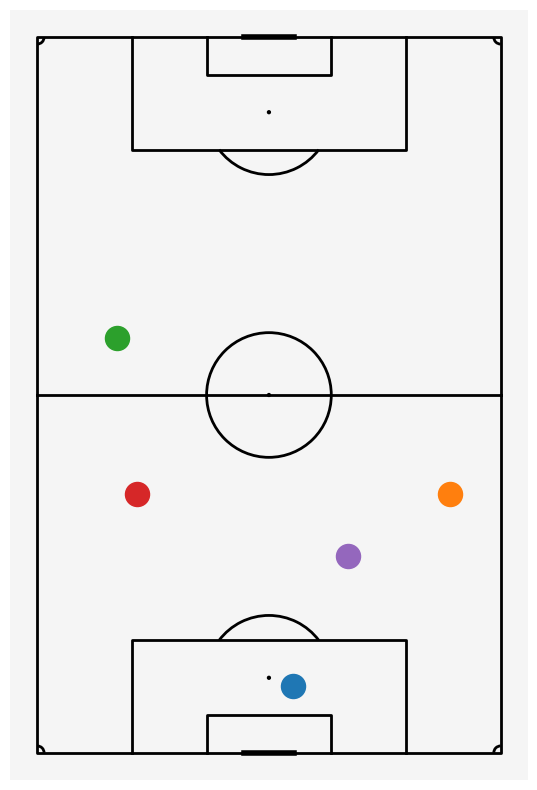

In [12]:
def longball_position(ax, team_name):
    team_df = df[(df['teamName']==team_name) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Longball')) & 
                 (~df['qualifiers'].str.contains('FreeKick|Corner|ThrowIn'))]
    pitch = VerticalPitch(pitch_type='uefa', pitch_color=bg_color, line_color=line_color, linewidth=2, corner_arcs=True)
    pitch.draw(ax=ax)

    # GK
    gk = team_df[team_df['position']=='GK']
    avg_hgk = gk['x'].median()
    avg_wgk = gk['y'].median()
    ax.scatter(avg_wgk, avg_hgk, s=300)

    # FullBacks
    right = team_df[team_df['position'].isin(['DR', 'DMR'])]
    left = team_df[team_df['position'].isin(['DL', 'DML'])]
    avg_hr = right['x'].median()
    avg_hl = left['x'].median()
    avg_wr = right['y'].median()
    avg_wl = left['y'].median()
    ax.scatter(avg_wr, avg_hr, s=300)
    ax.scatter(avg_wl, avg_hl, s=300)
    
    # CBs
    match_count = team_df['match_id'].unique()
    cb_counts_per_match = {}

    for match in match_count:
        no_cb = team_df[(team_df['match_id'] == match) & (team_df['position'] == 'DC')]
        no_cb = no_cb['name'].unique()
        cb_counts_per_match[match] = len(no_cb)

    # List of CB counts across matches
    cb_counts = list(cb_counts_per_match.values())
    most_common_cb_count = mode(cb_counts)

    if most_common_cb_count == 2:
        cb_df = team_df[team_df['position']=='DC']
        cb_avg = cb_df.groupby('name', as_index=False)[['x', 'y']].median()
        lcb = cb_avg[cb_avg['y']>34]
        rcb = cb_avg[cb_avg['y']<34]
        lcb_avg_y = lcb['y'].median()
        rcb_avg_y = rcb['y'].median()
        lcb_avg_x = lcb['x'].median()
        rcb_avg_x = rcb['x'].median()
        avg_x = cb_df['x'].median()
        ax.scatter(lcb_avg_y, lcb_avg_x, s=300)
        ax.scatter(rcb_avg_y, rcb_avg_x, s=300)
    else:
        cb_df = team_df[team_df['position']=='DC']
        cb_avg = cb_df.groupby('name', as_index=False)[['x', 'y']].median()
        lcb = cb_avg[cb_avg['y']>43]
        mcb = cb_avg[(cb_avg['y']<43) & (cb_avg['y']>25)]
        rcb = cb_avg[cb_avg['y']<25]
        lcb_avg_y = lcb['y'].median()
        rcb_avg_y = rcb['y'].median()
        mcb_avg_y = mcb['y'].median()
        lcb_avg_x = lcb['x'].median()
        rcb_avg_x = rcb['x'].median()
        mcb_avg_x = mcb['x'].median()
        avg_x = cb_df['x'].median()

    return

fig, ax = plt.subplots(figsize=(10,10))
longball_position(ax, 'Girona')

# Pitch Zone Wise

In [121]:
def sorting_func(team_name):
    dfteam = df[(df['qualifiers'].str.contains('Longball')) & (df['teamName']==team_name) &
                (~df['qualifiers'].str.contains('Corner|Freekick|ThrowIn|GoalKick|Cross'))]
    
    lbc = len(dfteam)
    return lbc

def long_ball_zone(ax, team_name):
    dfteam = df[(df['qualifiers'].str.contains('Longball')) & (df['teamName']==team_name) &
                (~df['qualifiers'].str.contains('Corner|Freekick|ThrowIn|GoalKick|Cross'))]
    pitch = VerticalPitch(pitch_type='uefa', pitch_color=bg_color, linewidth=2, line_zorder=3, corner_arcs=True)
    pitch.draw(ax=ax)
    ax.set_xlim(68.5,-0.5)
    # ax.set_ylim(-0.5,105.5)
    
    lbc = len(dfteam)

    cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors", [bg_color, col1], N=20)
    bin_statistic = pitch.bin_statistic(dfteam.x, dfteam.y, bins=(6,5), statistic='count', normalize=True)
    pitch.heatmap(bin_statistic, ax=ax, cmap=cmap, edgecolors='#f8f8f8')
    labels = pitch.label_heatmap(bin_statistic, color=line_color, fontsize=15, ax=ax, ha='center', va='center', str_format='{:.0%}',
                                 fontproperties=custom_font_thin)

    ax.text(55, 120, team_name, fontsize=20, fontweight='bold', ha='left', va='center', fontproperties=custom_font)
    ax.text(55, 110, f'OpenPlay Longballs: {lbc}', fontsize=13, ha='left', va='center', fontproperties=custom_font_thin)
    IMAGE_URL = f'file:///D:/FData/club_teams_logo/all_league%20-%20Copy/{team_name}.html'
    image = Image.open(urlopen(IMAGE_URL))
    ax_image = pitch.inset_image(115, 66, image, height=12, alpha=1, ax=ax)

    return

# fig,ax = plt.subplots(figsize=(10,10))
# long_ball_zone(ax, 'Barcelona')

C:\Users\h\AppData\Local\Temp\ipykernel_16512\3794366753.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  (~df['qualifiers'].shift(1).str.contains('Corner|Freekick|ThrowIn|GoalKick|Cross').fillna(False))]


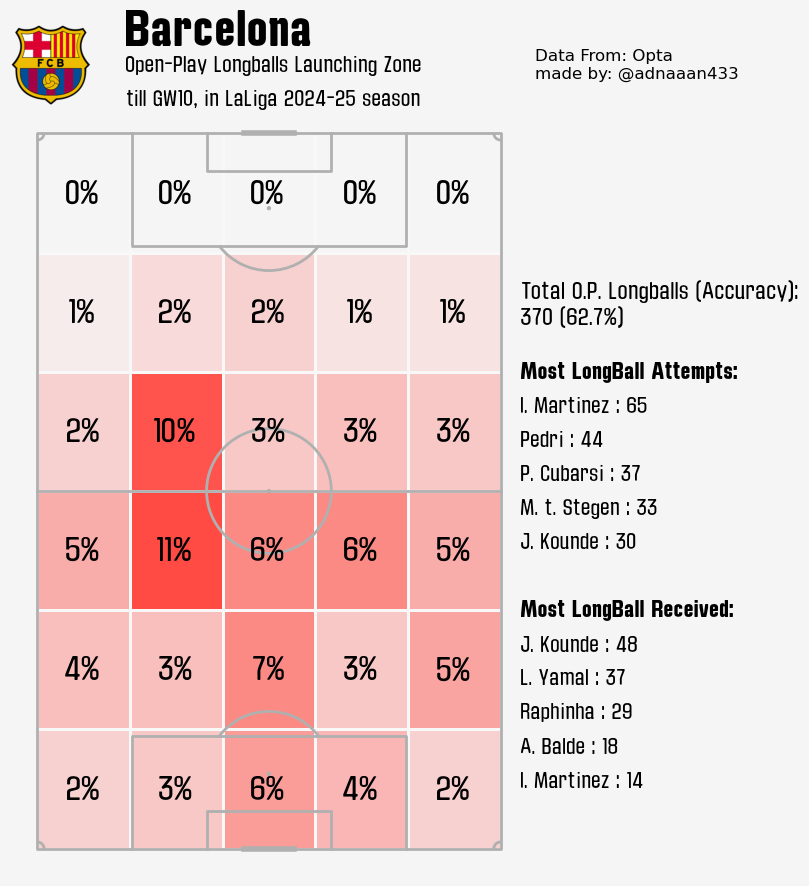

In [124]:
def long_ball_zone(ax, team_name):
    dfteam = df[(df['qualifiers'].str.contains('Longball')) & (df['teamName']==team_name) &
                (~df['qualifiers'].str.contains('Corner|Freekick|ThrowIn|GoalKick|Cross'))]
    accurate = dfteam[dfteam['outcomeType']=='Successful']
    accuracy = round((len(accurate)/len(dfteam))*100, 2)

    name_counts = dfteam['shortName'].value_counts()
    name_counts_df = name_counts.reset_index()
    name_counts_df.columns = ['name', 'lb_count']
    name_counts_df = name_counts_df.sort_values(by='lb_count', ascending=False)  
    name_counts_df = name_counts_df.reset_index()

    receiver_df = df[(df['qualifiers'].shift(1).str.contains('Longball')) & (df['teamName'].shift(1)==team_name) & (df['outcomeType'].shift(1)=='Successful') &
                (~df['qualifiers'].shift(1).str.contains('Corner|Freekick|ThrowIn|GoalKick|Cross').fillna(False))]
    rece_name_counts = receiver_df['shortName'].value_counts()
    rece_name_counts_df = rece_name_counts.reset_index()
    rece_name_counts_df.columns = ['name', 'lb_count']
    rece_name_counts_df = rece_name_counts_df.sort_values(by='lb_count', ascending=False)  
    rece_name_counts_df = rece_name_counts_df.reset_index()
    
    pitch = VerticalPitch(pitch_type='uefa', pitch_color=bg_color, linewidth=2, line_zorder=3, corner_arcs=True)
    pitch.draw(ax=ax)
    # ax.set_xlim(68.5,-0.5)
    # ax.set_ylim(-0.5,105.5)
    
    lbc = len(dfteam)

    cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors", [bg_color, col1], N=20)
    bin_statistic = pitch.bin_statistic(dfteam.x, dfteam.y, bins=(6,5), statistic='count', normalize=True)
    pitch.heatmap(bin_statistic, ax=ax, cmap=cmap, edgecolors='#f8f8f8')
    labels = pitch.label_heatmap(bin_statistic, color=line_color, fontsize=20, ax=ax, ha='center', va='center', str_format='{:.0%}',
                                 fontproperties=custom_font_thin)

    ax.text(55, 120, f'{team_name}', fontsize=30, fontweight='bold', ha='left', va='center', fontproperties=custom_font)
    ax.text(55, 115, f'Open-Play Longballs Launching Zone', fontsize=13, ha='left', va='center', fontproperties=custom_font_thin)
    ax.text(55, 110, f'till GW10, in LaLiga 2024-25 season', fontsize=13, ha='left', va='center', fontproperties=custom_font_thin)

    ax.text(-3, 80, f'Total O.P. Longballs (Accuracy):\n{lbc} ({accuracy}%)', fontsize=14, ha='left', va='center', fontproperties=custom_font_thin)
    
    ax.text(-3, 80-10, f'Most LongBall Attempts:', fontsize=14, ha='left', va='center', fontproperties=custom_font)
    ax.text(-3, 80-15, f'{name_counts_df.name[0]} : {name_counts_df.lb_count[0]}', fontsize=13, ha='left', va='center', fontproperties=custom_font_thin)
    ax.text(-3, 80-20, f'{name_counts_df.name[1]} : {name_counts_df.lb_count[1]}', fontsize=13, ha='left', va='center', fontproperties=custom_font_thin)
    ax.text(-3, 80-25, f'{name_counts_df.name[2]} : {name_counts_df.lb_count[2]}', fontsize=13, ha='left', va='center', fontproperties=custom_font_thin)
    ax.text(-3, 80-30, f'{name_counts_df.name[3]} : {name_counts_df.lb_count[3]}', fontsize=13, ha='left', va='center', fontproperties=custom_font_thin)
    ax.text(-3, 80-35, f'{name_counts_df.name[4]} : {name_counts_df.lb_count[4]}', fontsize=13, ha='left', va='center', fontproperties=custom_font_thin)
    
    ax.text(-3, 45-10, f'Most LongBall Received:', fontsize=14, ha='left', va='center', fontproperties=custom_font)
    ax.text(-3, 45-15, f'{rece_name_counts_df.name[0]} : {rece_name_counts_df.lb_count[0]}', fontsize=13, ha='left', va='center', fontproperties=custom_font_thin)
    ax.text(-3, 45-20, f'{rece_name_counts_df.name[1]} : {rece_name_counts_df.lb_count[1]}', fontsize=13, ha='left', va='center', fontproperties=custom_font_thin)
    ax.text(-3, 45-25, f'{rece_name_counts_df.name[2]} : {rece_name_counts_df.lb_count[2]}', fontsize=13, ha='left', va='center', fontproperties=custom_font_thin)
    ax.text(-3, 45-30, f'{rece_name_counts_df.name[3]} : {rece_name_counts_df.lb_count[3]}', fontsize=13, ha='left', va='center', fontproperties=custom_font_thin)
    ax.text(-3, 45-35, f'{rece_name_counts_df.name[4]} : {rece_name_counts_df.lb_count[4]}', fontsize=13, ha='left', va='center', fontproperties=custom_font_thin)
    
    IMAGE_URL = f'file:///D:/FData/club_teams_logo/all_league%20-%20Copy/{team_name}.html'
    image = Image.open(urlopen(IMAGE_URL))
    ax_image = pitch.inset_image(115, 66, image, height=12, alpha=1, ax=ax)

    ax.text(-5, 115, 'Data From: Opta\nmade by: @adnaaan433', fontsize=12, ha='left', va='center')

    return

fig,ax = plt.subplots(figsize=(10,10), facecolor=bg_color)
long_ball_zone(ax, 'Barcelona')

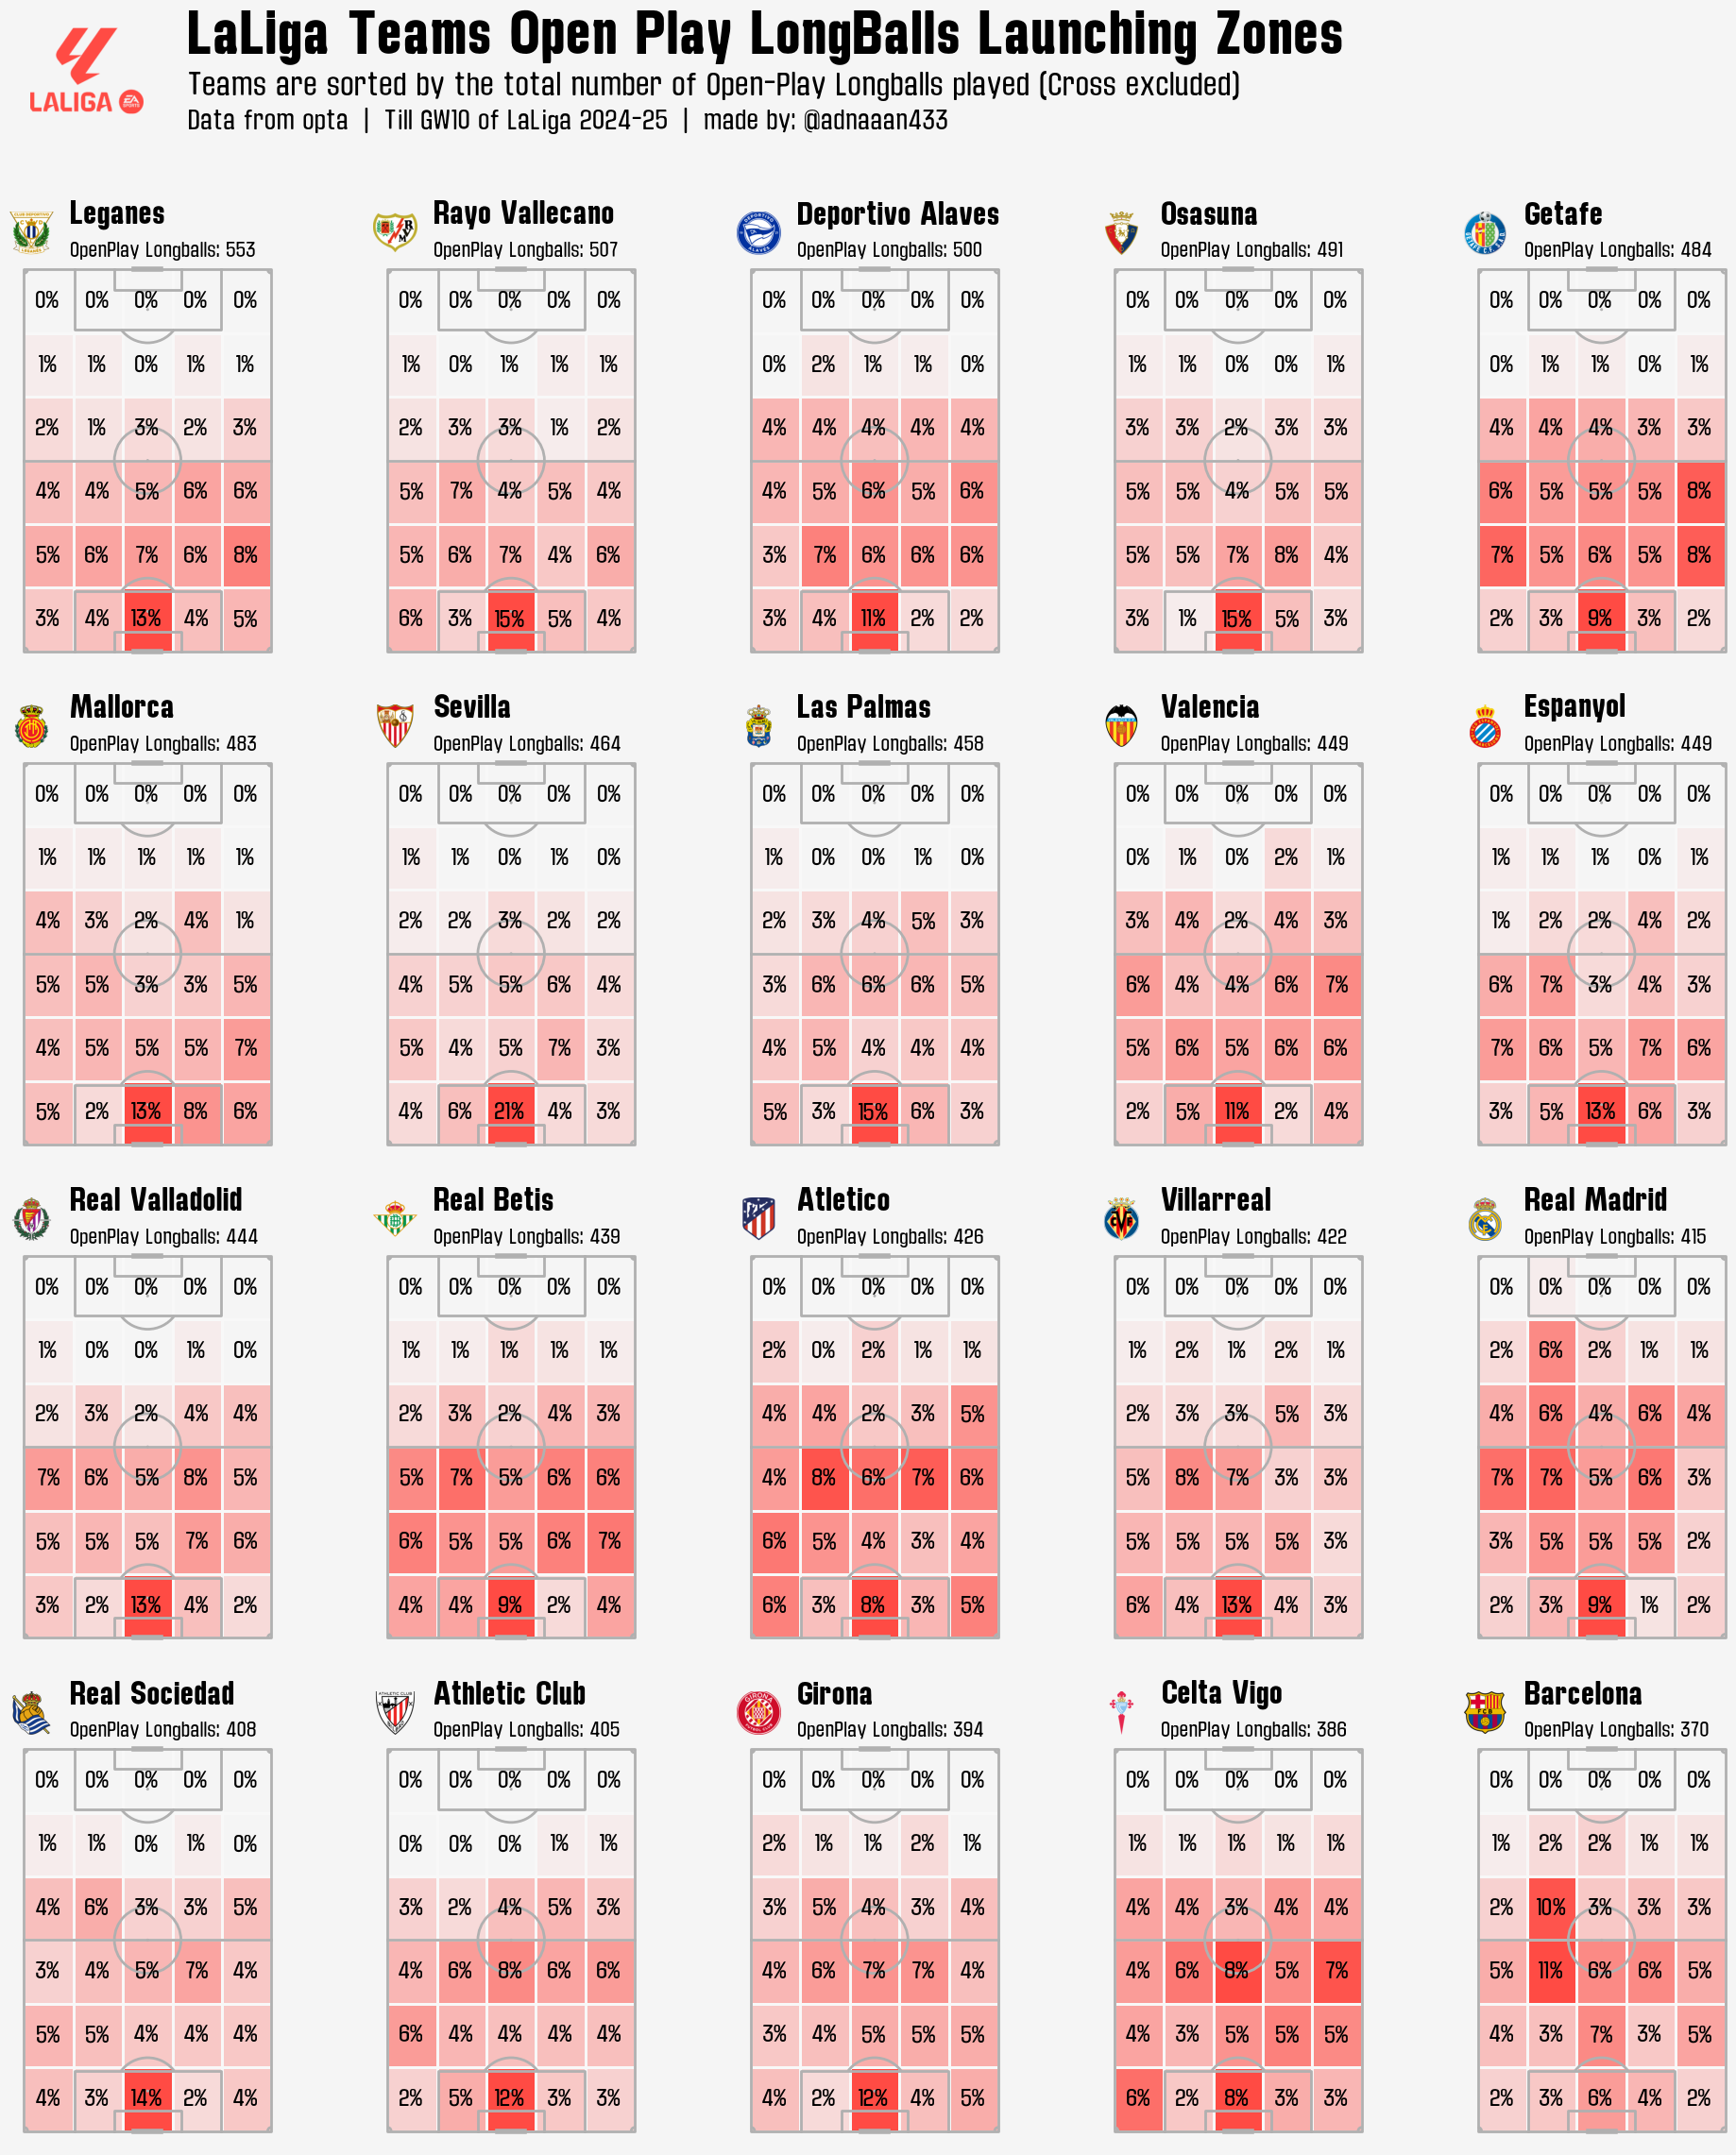

In [73]:
# List of team names
team_names = df.teamName.unique()

# Create a DataFrame with team names and their diffe values
team_stats = pd.DataFrame({'teamName': team_names})
team_stats['count'] = team_stats['teamName'].apply(sorting_func)
team_stats_sorted = team_stats.sort_values(by='count', ascending=False)

# Create the figure and axes for a 4x5 grid
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(24, 26), facecolor=bg_color)

# Flatten the axes array to easily loop through it
axes = axes.ravel()

# Loop through the sorted team names and corresponding axes
for i, row in enumerate(team_stats_sorted.itertuples()):
    team_name = row.teamName
    long_ball_zone(axes[i], team_name)


fig.text(0.21, 0.98, 'LaLiga Teams Open Play LongBalls Launching Zones', fontsize=38, fontweight='bold', ha='left', va='top', fontproperties=custom_font)
fig_text(0.21, 0.955, "Teams are sorted by the total number of Open-Play Longballs played (Cross excluded)",
         fontsize=20, ha='left', va='top', fontproperties=custom_font_thin)
fig.text(0.21, 0.94, "Data from opta  |  Till GW10 of LaLiga 2024-25  |  made by: @adnaaan433",
         fontsize=17, ha='left', va='top', fontproperties=custom_font_thin)

image_url = 'file:///D:/FData/Leagues_logos/LaLiga%20.html'
image = urlopen(image_url)
image = Image.open(image)
ax_image = add_image(image, fig, left=0.14, bottom=0.93, width=0.05, height=0.05)